In [10]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import numpy as np
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.stattools import adfuller
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import r2_score


## Pre Processing

In [2]:
data = pd.read_csv("data/daily_in_situ_co2_mlo.csv")
data.columns = data.columns.str.replace(' ', '')
data['Date'] = pd.to_datetime(data['Yr'].astype(str) + '-' + data['Mn'].astype(str) + '-' + data['Dy'].astype(str))
data.drop(['Yr', 'Mn', 'Dy','scale','sta','NB'], axis=1, inplace=True)
date_column='Date'
target_column='CO2'
data

,CO2,Date
0,NaN,1958-01-01
1,NaN,1958-01-02
2,NaN,1958-01-03
3,NaN,1958-01-04
4,NaN,1958-01-05
...,...,...
24222,NaN,2024-04-26
24223,NaN,2024-04-27
24224,NaN,2024-04-28
24225,NaN,2024-04-29


In [3]:
data.info()
data['CO2'] = data['CO2'].str.strip()
data.columns

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 24227 entries, 0 to 24226
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   CO2     24227 non-null  object        
 1   Date    24227 non-null  datetime64[ns]
dtypes: datetime64[ns](1), object(1)
memory usage: 378.7+ KB


Index(['CO2', 'Date'], dtype='object')

In [4]:
data.replace({'CO2': {'NaN': np.nan}}, inplace=True)
data = data.dropna()
data.isna().sum()
data

,CO2,Date
88,316.16,1958-03-30
89,316.69,1958-03-31
91,317.67,1958-04-02
92,317.76,1958-04-03
93,317.09,1958-04-04
...,...,...
24192,424.40,2024-03-27
24193,424.57,2024-03-28
24194,425.19,2024-03-29
24195,425.92,2024-03-30


## NORMALIZATION

In [9]:
data.describe()

C:\Users\lenovo\AppData\Local\Temp\ipykernel_22660\3175101911.py:1: FutureWarning: Treating datetime data as categorical rather than numeric in `.describe` is deprecated and will be removed in a future version of pandas. Specify `datetime_is_numeric=True` to silence this warning and adopt the future behavior now.
  data.describe()


,CO2,Date
count,17909,17909
unique,8603,17909
top,319.93,1958-03-30 00:00:00
freq,9,1
first,NaN,1958-03-30 00:00:00
last,NaN,2024-04-03 00:00:00


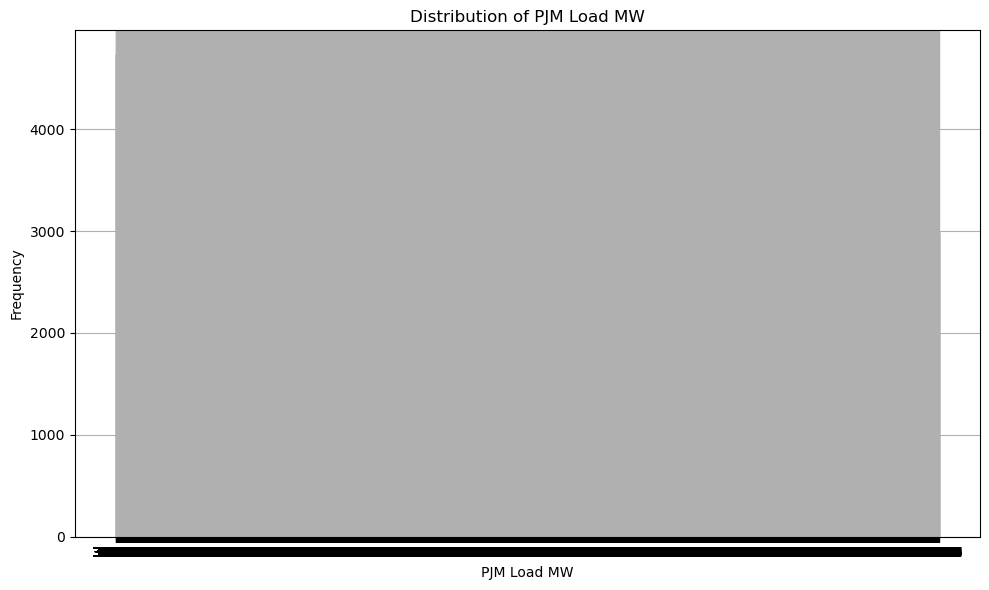

In [8]:
plt.figure(figsize=(10, 6))
plt.hist(data[target_column], bins=5, color='blue', edgecolor='black')
plt.title('Distribution of PJM Load MW')
plt.xlabel('PJM Load MW')
plt.ylabel('Frequency')
plt.grid(True)
plt.tight_layout()
plt.show()

In [35]:
numerical_columns = [target_column]
data_to_normalize = data[numerical_columns]
scaler = MinMaxScaler()
normalized_data = scaler.fit_transform(data_to_normalize)
normalized_df = pd.DataFrame(normalized_data, columns=numerical_columns)
normalized_df['Date'] = data[date_column]
normalized_df.head()

,CO2,Date
0,0.033169,NaT
1,0.037759,NaT
2,0.046246,NaT
3,0.047025,NaT
4,0.041223,NaT


## Standarization check

pValue of adfuller test is : 0.8913181320471915


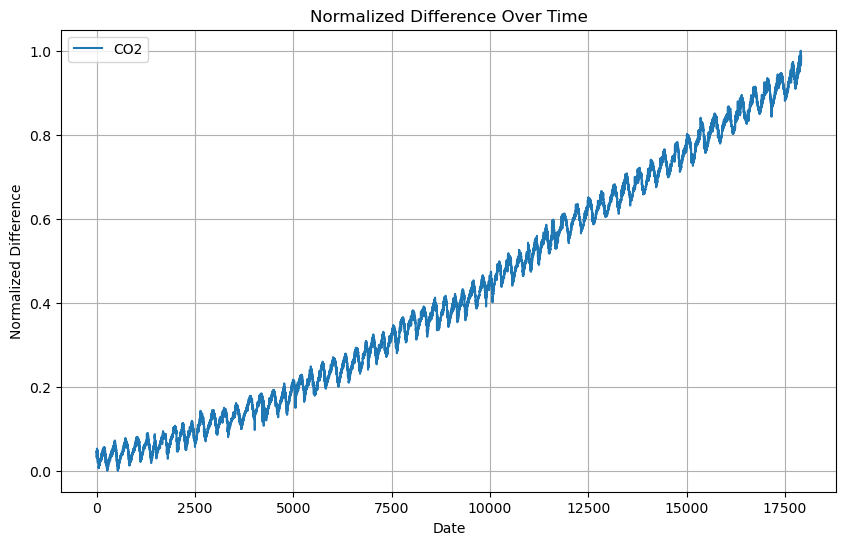

In [36]:
from statsmodels.tsa.stattools import adfuller
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_df.index, normalized_df[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()

## Standarization
### Differencing

pValue of adfuller test is : 5.851751444326034e-30


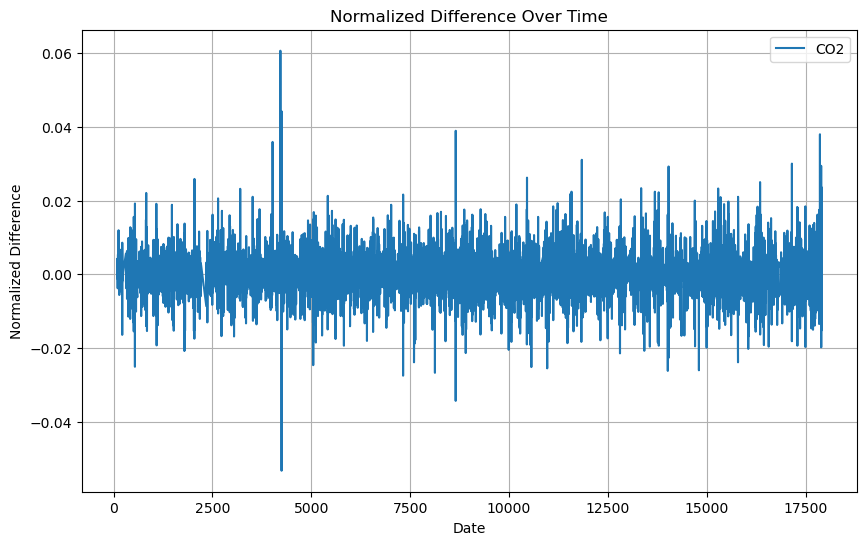

,CO2,Date
88,-0.000520,1958-03-30
89,-0.000953,1958-03-31
91,0.000866,1958-04-02
92,0.002078,1958-04-03
93,-0.000087,1958-04-04
...,...,...
17904,-0.015242,2007-01-08
17905,0.001472,2007-01-09
17906,0.005369,2007-01-10
17907,0.006322,2007-01-11


In [37]:
normalized_difference=normalized_df.copy()
for column in numerical_columns:
    normalized_difference[f'{column}'] = normalized_difference[column].diff()
normalized_difference.dropna(inplace=True)
adftest=adfuller(normalized_difference[target_column])
print('pValue of adfuller test is :',adftest[1])
plt.figure(figsize=(10, 6))
plt.plot(normalized_difference.index, normalized_difference[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_difference

### Logarithmic

pValue of adfuller test is : 0.02970290183164149


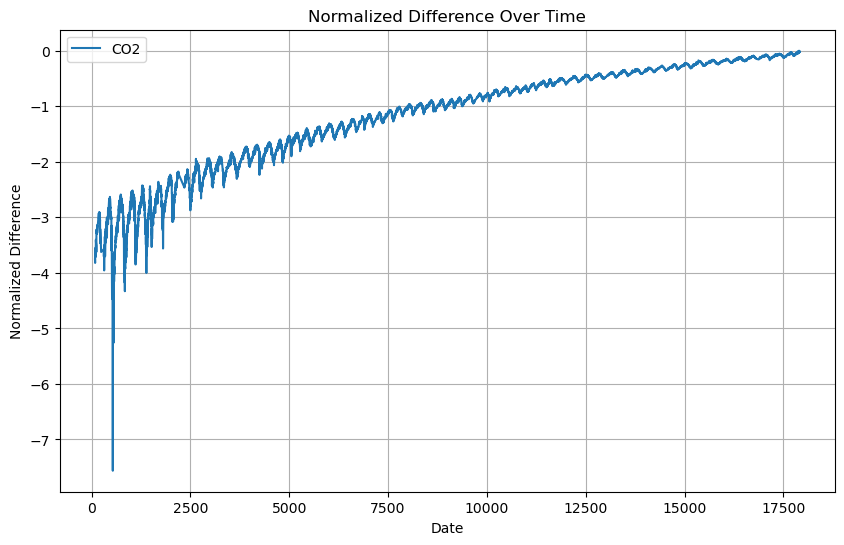

,CO2,Date
88,-3.759470,1958-03-30
89,-3.801221,1958-03-31
91,-3.820791,1958-04-02
92,-3.730163,1958-04-03
93,-3.733780,1958-04-04
...,...,...
17904,-0.029887,2007-01-08
17905,-0.028371,2007-01-09
17906,-0.022863,2007-01-10
17907,-0.016415,2007-01-11


In [38]:
normalized_log=normalized_df
for column in numerical_columns:
    normalized_log[f'{column}'] = normalized_log[column].apply(lambda x: np.log(x) if x != 0 else 0)
adftest=adfuller(normalized_log[target_column])
print('pValue of adfuller test is :',adftest[1]) 
normalized_log.dropna(inplace=True)
plt.figure(figsize=(10, 6))
plt.plot(normalized_log.index, normalized_log[target_column], label=target_column)

plt.xlabel('Date')
plt.ylabel('Normalized Difference')
plt.title('Normalized Difference Over Time')
plt.legend()
plt.grid(True)
plt.show()
normalized_log

### Breakdown for Stationary Data
Upon testing both difference and logarithmic method i have choosen Differencing method because the p value is less then 0.05

In [39]:
normalized_df=normalized_log
adftest=adfuller(normalized_df[target_column])
print('pValue of adfuller test is :',adftest[1]) 

pValue of adfuller test is : 0.14024618450723897


## ARIMA MODEL

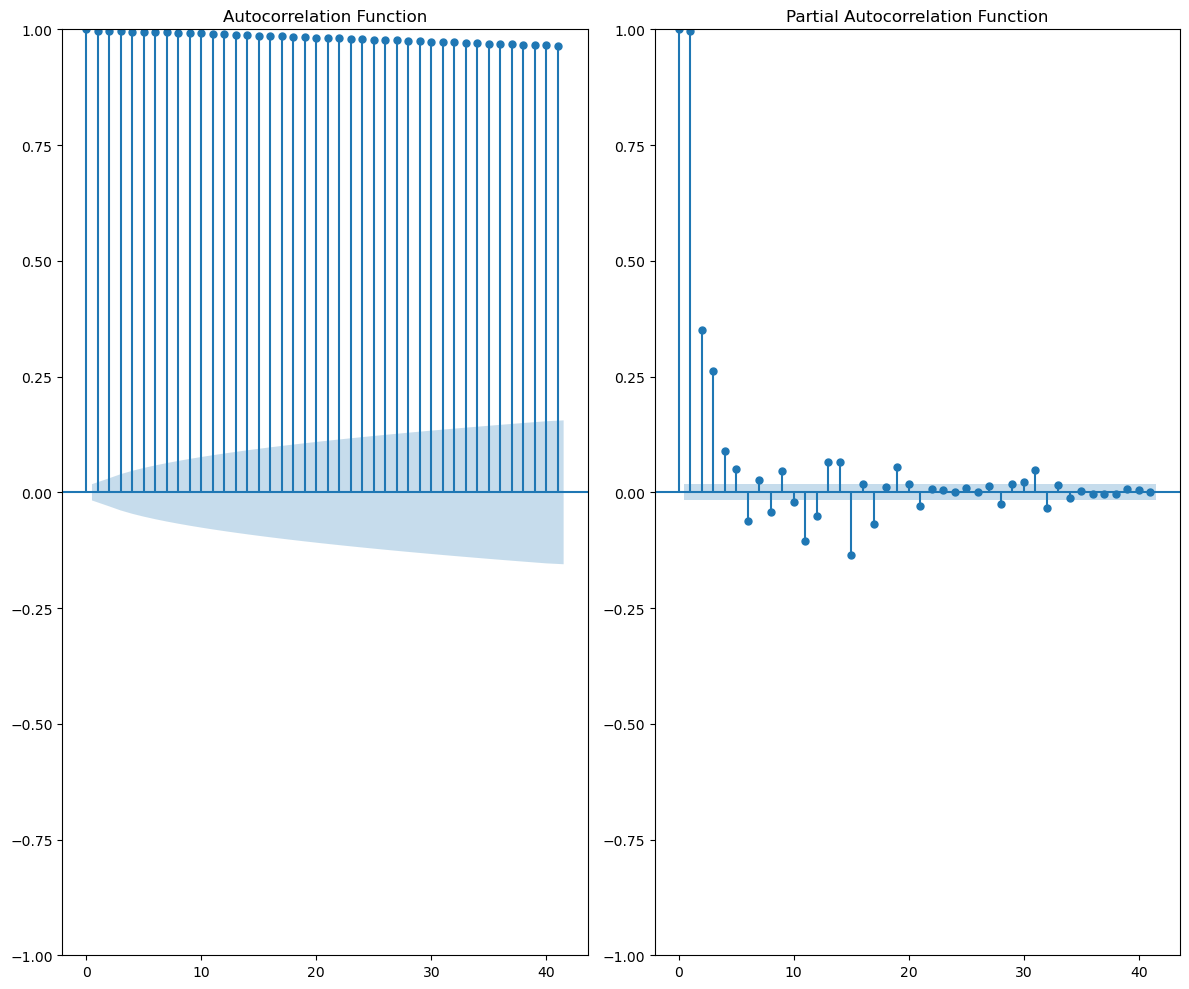

In [40]:
y = normalized_df[target_column]
lag_acf = acf(y, nlags=25)
lag_pacf = pacf(y, nlags=25, method='ols')
plt.figure(figsize=(12, 10))
plt.subplot(121)
plot_acf(y, ax=plt.gca())
plt.title('Autocorrelation Function')
plt.subplot(122)
plot_pacf(y, ax=plt.gca())
plt.title('Partial Autocorrelation Function')
plt.tight_layout()
plt.show()


In [42]:
dummy=normalized_df.copy()
dummy['Date'] = pd.to_datetime(dummy['Date'])
dummy.set_index('Date', inplace=True)
print('Results of Dickey-Fuller Test:')
dftest = adfuller(dummy[target_column], autolag='AIC')
dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
print("Adfuller Output")
dfoutput

Results of Dickey-Fuller Test:
Adfuller Output


Test Statistic                    -2.405300
p-value                            0.140246
#Lags Used                        41.000000
Number of Observations Used    12385.000000
dtype: float64

In [43]:
arima_model = ARIMA(y, order=(1,2,0))
arima_result = arima_model.fit()
print(arima_result.summary())
predictionsArima = arima_result.predict()

C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\lenovo\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:                    CO2   No. Observations:                12427
Model:                 ARIMA(1, 2, 0)   Log Likelihood               12706.924
Date:                Fri, 10 May 2024   AIC                         -25409.847
Time:                        18:03:08   BIC                         -25394.992
Sample:                             0   HQIC                        -25404.873
                              - 12427                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.6010      0.000  -1706.511      0.000      -0.602      -0.600
sigma2         0.0076   3.93e-06   1926.400      0.000       0.008       0.008
Ljung-Box (L1) (Q):                1222.43   Jarque-

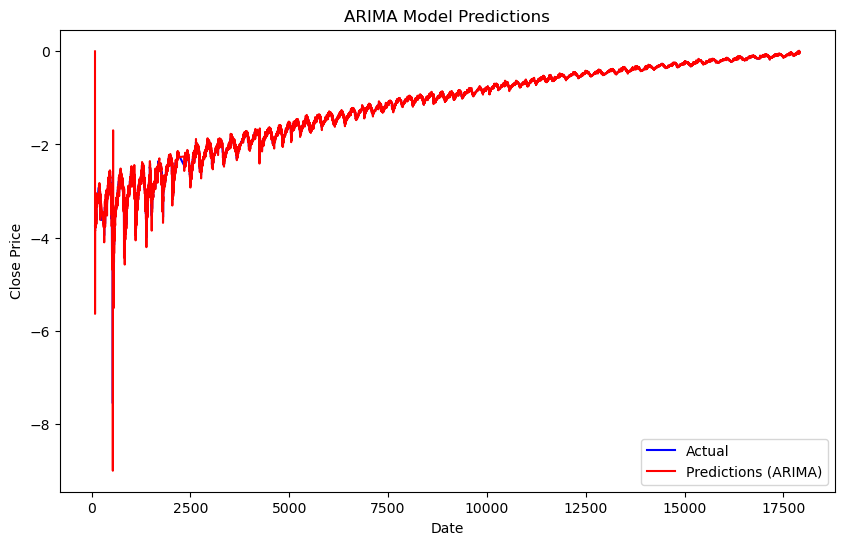

In [44]:
predictions_arima = arima_result.predict()

# Plotting
plt.figure(figsize=(10, 6))
plt.plot(y.index, y, label='Actual', color='blue')
plt.plot(y.index, predictions_arima, label='Predictions (ARIMA)', color='red')
plt.title('ARIMA Model Predictions')
plt.xlabel('Date')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [45]:
predictionsArima_aligned = predictionsArima[:-1]  #remove the last prediction to match the length of y
rmse_arima = np.sqrt(mean_squared_error(y[1:], predictionsArima_aligned))
mae_arima = mean_absolute_error(y[1:], predictionsArima_aligned)
mape_arima = np.mean(np.abs((y[1:] - predictionsArima_aligned) / y[1:])) * 100
r_squared = r2_score(y[1:], predictionsArima_aligned)

print("ARIMA Performance Metrics:")
print("R-squared:", r_squared)
print("RMSE:", rmse_arima)
print("MAE:", mae_arima)
print("MAPE:", mape_arima)

ARIMA Performance Metrics:
R-squared: 0.9881754322324666
RMSE: 0.09885179791708516
MAE: 0.02946048947850717
MAPE: inf
